In [1]:
import numpy as np
import pandas as pd
import os  
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import io
import dateutil
import collections
import time
from datetime import datetime
import wrds
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

wrds is the package for the Wharton Database. wrds.Connection() connects to the database and is needed for each command

list_libraries() list all libraries that can be connected to from the wrds package in python

In [3]:
list_libraries = db.list_libraries()

The library needed is comp and the table within that library is funda. This represents the North America Fundamentals Annuals within Compustat Capital IQ.

Comp.Funda Variables:

AT -- Assets - Total                BKVLPS -- Book Value Per Share

COGS -- Cost of Goods Sold           DVT -- Dividends - Total

IB -- Income Before Extraordinary Items    LT -- Liabilities - Total

NI -- Net Income (Loss)             REVT -- Revenue - Total        SALE -- Sales/Turnover (Net)

SEQ -- Stockholders' Equity - Total  


Set Arguments for SQL query

Start_year is the first year to query

End_year is one year past the year to query

Example: Start_year = 1990 and End_year = 2001

This will query 1990 to 2000
    
Query_string is the raw SQL query as a string


In [6]:
Start_year = 1983
End_year = 2009

In [5]:
db.describe_table(library="comp", table="funda")[347:356]

Approximately 787647 rows in comp.funda.


,name,nullable,type
347,govtown,True,DOUBLE PRECISION
348,gp,True,DOUBLE PRECISION
349,gphbl,True,DOUBLE PRECISION
350,gplbl,True,DOUBLE PRECISION
351,gpobl,True,DOUBLE PRECISION
352,gprbl,True,DOUBLE PRECISION
353,gptbl,True,DOUBLE PRECISION
354,gwo,True,DOUBLE PRECISION
355,hedgegl,True,DOUBLE PRECISION


In [7]:
Query_string ="select gvkey,fyear,tic,conm,at,bkvlps,cogs,dvt,ib,lt,ni,revt,sale,seq from comp.funda where gvkey='005073' OR gvkey='009563' OR gvkey='006066' OR gvkey='007875' OR gvkey='002176' OR gvkey='009667' OR gvkey='005047' OR gvkey='004839' OR gvkey='003022'  OR gvkey='006307' OR gvkey='011259'OR gvkey='007585' OR gvkey='005606' OR gvkey='003282' OR gvkey='005680' OR gvkey='006829' OR gvkey='004503'  OR gvkey='009899' OR gvkey='002136' OR gvkey='003813' OR gvkey='002991'  OR gvkey='009653'"

In [8]:
Full_db = db.raw_sql(Query_string)

If a list can be used in the raw sql command then it may be possible to make the process more automated. Right now the raw sql string has to be typed by hand. It may be possible to do a function with GVkey as input and the rest generated automatically.

In [9]:
years = list(range(Start_year,End_year))

In [10]:
DBfrom1982to2002 = Full_db[Full_db.fyear.isin(years)]

In [11]:
gvkeylist = set(DBfrom1982to2002['gvkey'].tolist())

In [12]:
DBfrom1982to2002nonans = DBfrom1982to2002.dropna(axis=0, how='any')

In [13]:
DBfrom1982to2002nonans = DBfrom1982to2002nonans.reset_index(drop=True)

In [14]:
features = ['at', 'bkvlps', 'cogs', 'dvt','ib','lt','ni','revt','sale','seq']
# Separating out the features
x = DBfrom1982to2002nonans.loc[:, features].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [15]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Principal Component 1', 'Principal Component 2'])

In [16]:
finalDf = pd.concat([principalDf, DBfrom1982to2002nonans[['conm', 'fyear']]], axis = 1).sort_values('fyear')

In [17]:
companylist = set(DBfrom1982to2002nonans['conm'].tolist())

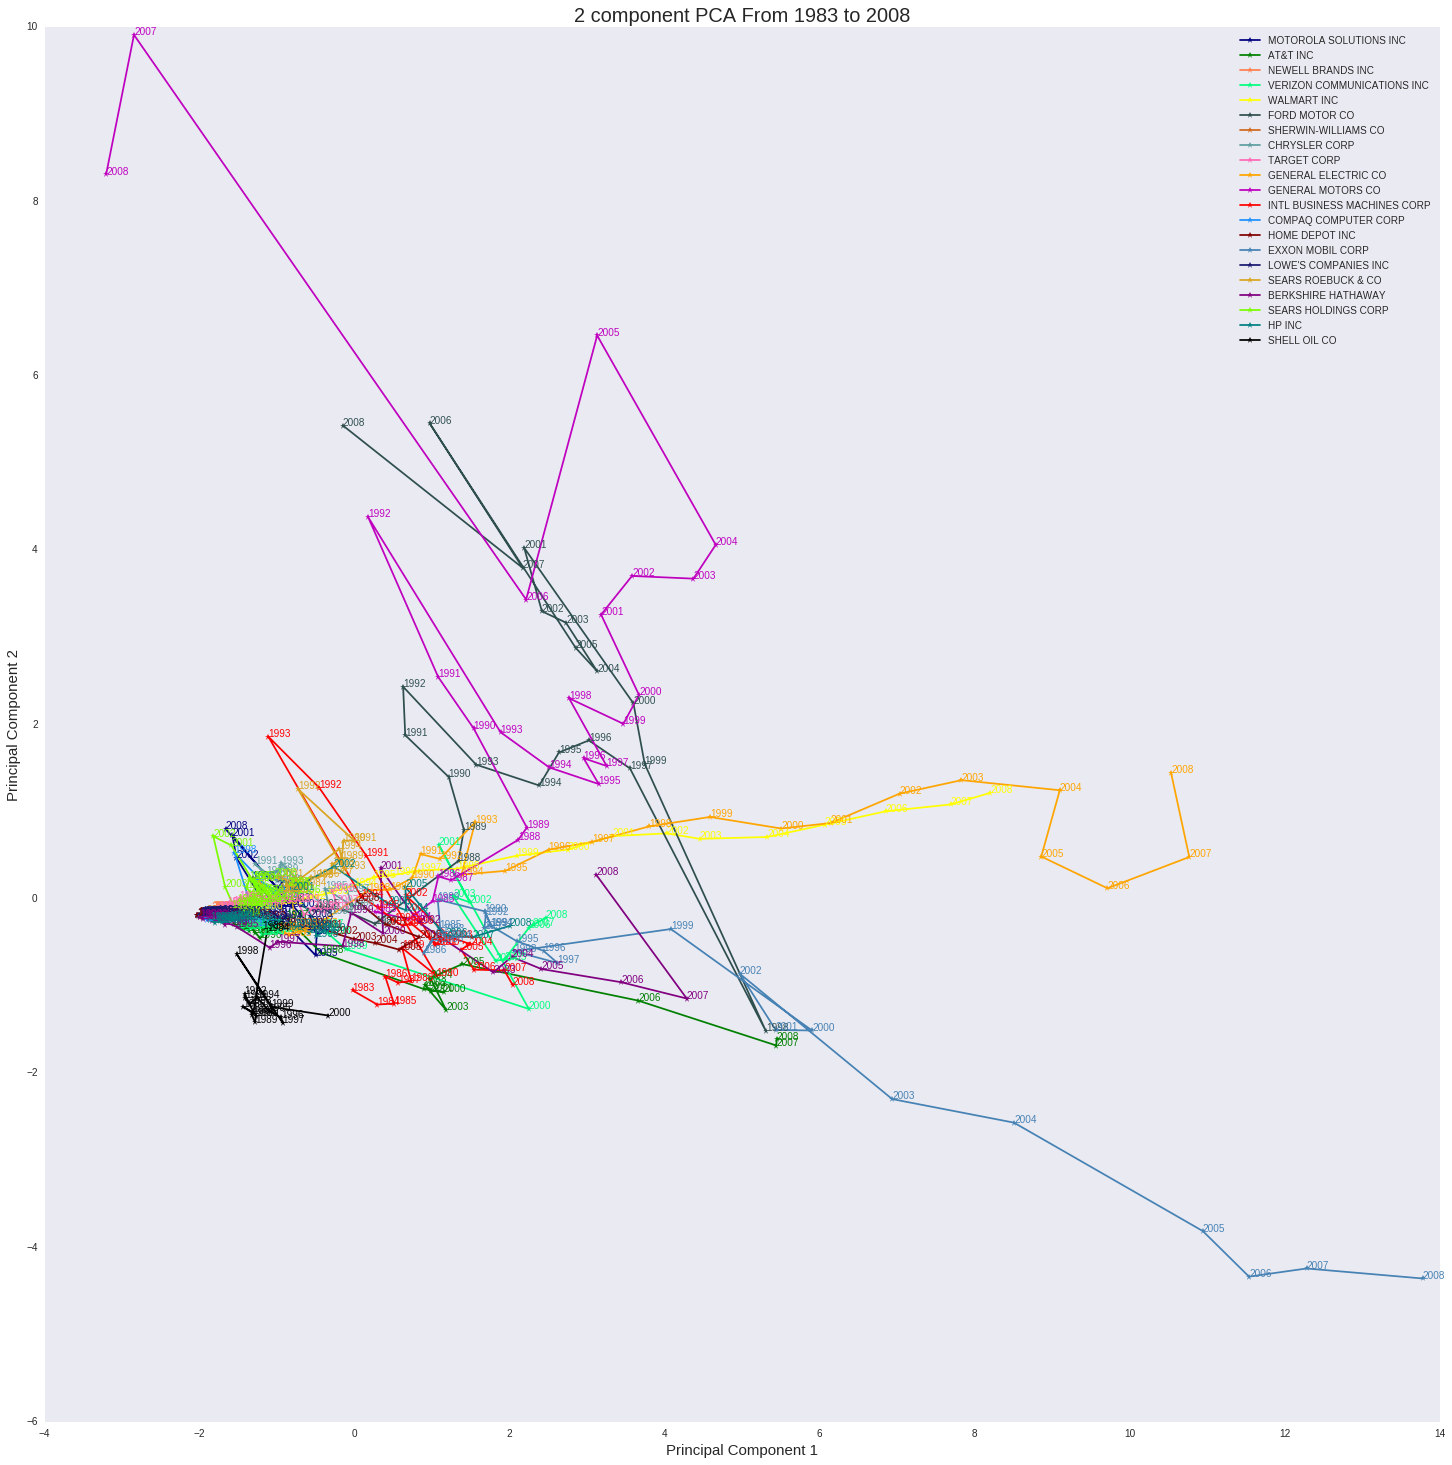

In [18]:
fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA From 1983 to 2008', fontsize = 20)
companylist = set(DBfrom1982to2002nonans['conm'].tolist())
colors = ['navy','g','coral','springgreen', 'yellow','darkslategray','chocolate','cadetblue','hotpink','orange', 'm','r','dodgerblue', 'maroon', 'steelblue', 'midnightblue', 'goldenrod', 'purple', 'lawngreen','teal','black']
for company, color in zip(companylist,colors):
    indicesToKeep = DBfrom1982to2002nonans['conm'] == company
    plt.plot(finalDf.loc[indicesToKeep, 'Principal Component 1']
               , finalDf.loc[indicesToKeep, 'Principal Component 2']
               , '-*'
               , c = color)
    for ttxt in zip(
            finalDf.loc[indicesToKeep, 'Principal Component 1'],
            finalDf.loc[indicesToKeep, 'Principal Component 2'],
            [ '%.0f'%y for y in finalDf.loc[indicesToKeep, 'fyear']]): 
        plt.text(ttxt[0], ttxt[1], ttxt[2], color = color)
ax.legend(companylist)
ax.grid()

In [19]:
Telecommunication = ['AT&T INC','VERIZON COMMUNICATIONS INC','MOTOROLA SOLUTIONS INC']
Oil = ['CHEVRON CORP','SHELL OIL CO','EXXON MOBIL CORP']
Auto =['CHRYSLER CORP','FORD MOTOR CO','GENERAL MOTORS CO']
Hardware = ["LOWE'S COMPANIES INC",'SHERWIN-WILLIAMS CO','HOME DEPOT INC']
Retail = ['WALMART INC','SEARS ROEBUCK & CO','TARGET CORP']
Conglomerate = ['GENERAL ELECTRIC CO','NEWELL BRANDS INC','BERKSHIRE HATHAWAY']
Computer = ['INTL BUSINESS MACHINES CORP','COMPAQ COMPUTER CORP','HP INC']

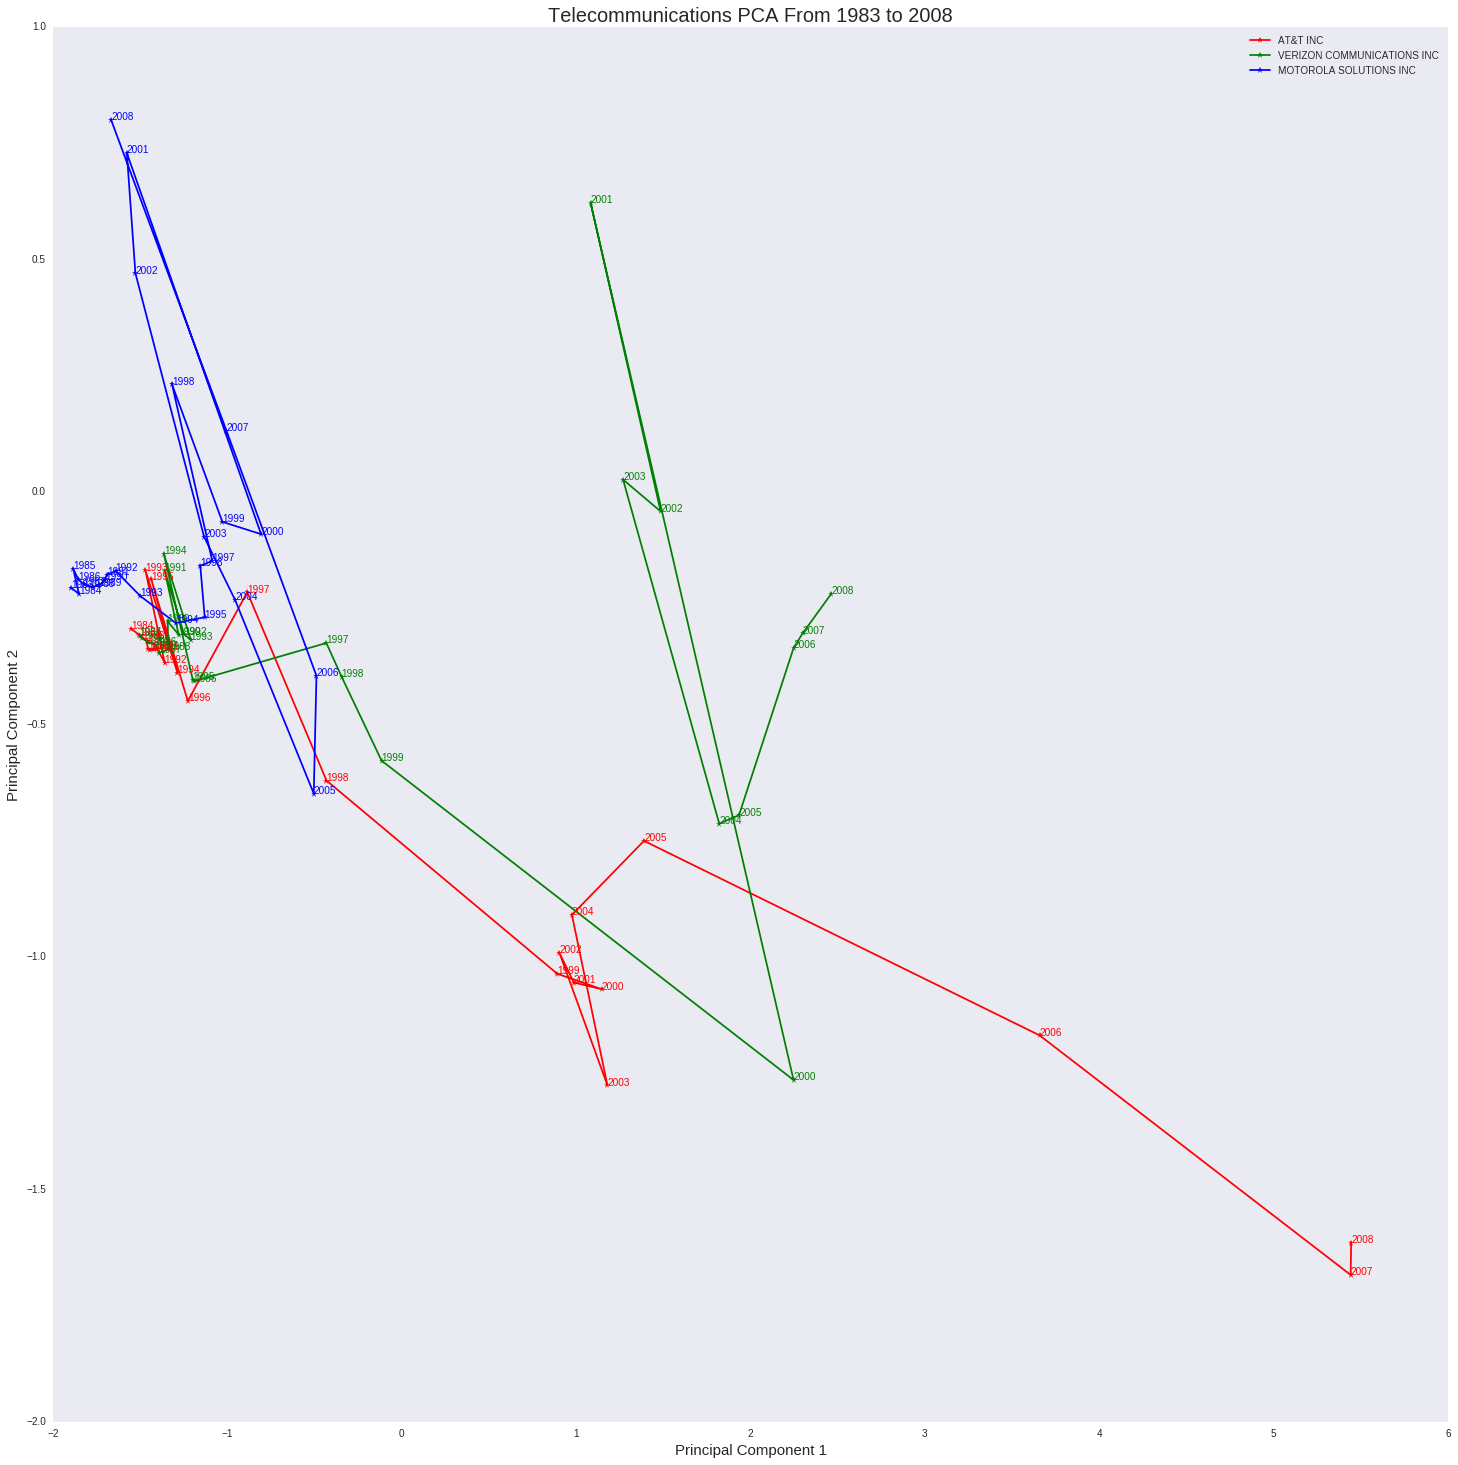

In [20]:
fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Telecommunications PCA From 1983 to 2008', fontsize = 20)
companylist = Telecommunication
colors = ['r','g','b']
for company, color in zip(companylist,colors):
    indicesToKeep = DBfrom1982to2002nonans['conm'] == company
    plt.plot(finalDf.loc[indicesToKeep, 'Principal Component 1']
               , finalDf.loc[indicesToKeep, 'Principal Component 2']
               , '-*'
               , c = color)
    for ttxt in zip(
            finalDf.loc[indicesToKeep, 'Principal Component 1'],
            finalDf.loc[indicesToKeep, 'Principal Component 2'],
            [ '%.0f'%y for y in finalDf.loc[indicesToKeep, 'fyear']]): 
        plt.text(ttxt[0], ttxt[1], ttxt[2], color = color)
ax.legend(companylist)
ax.grid()

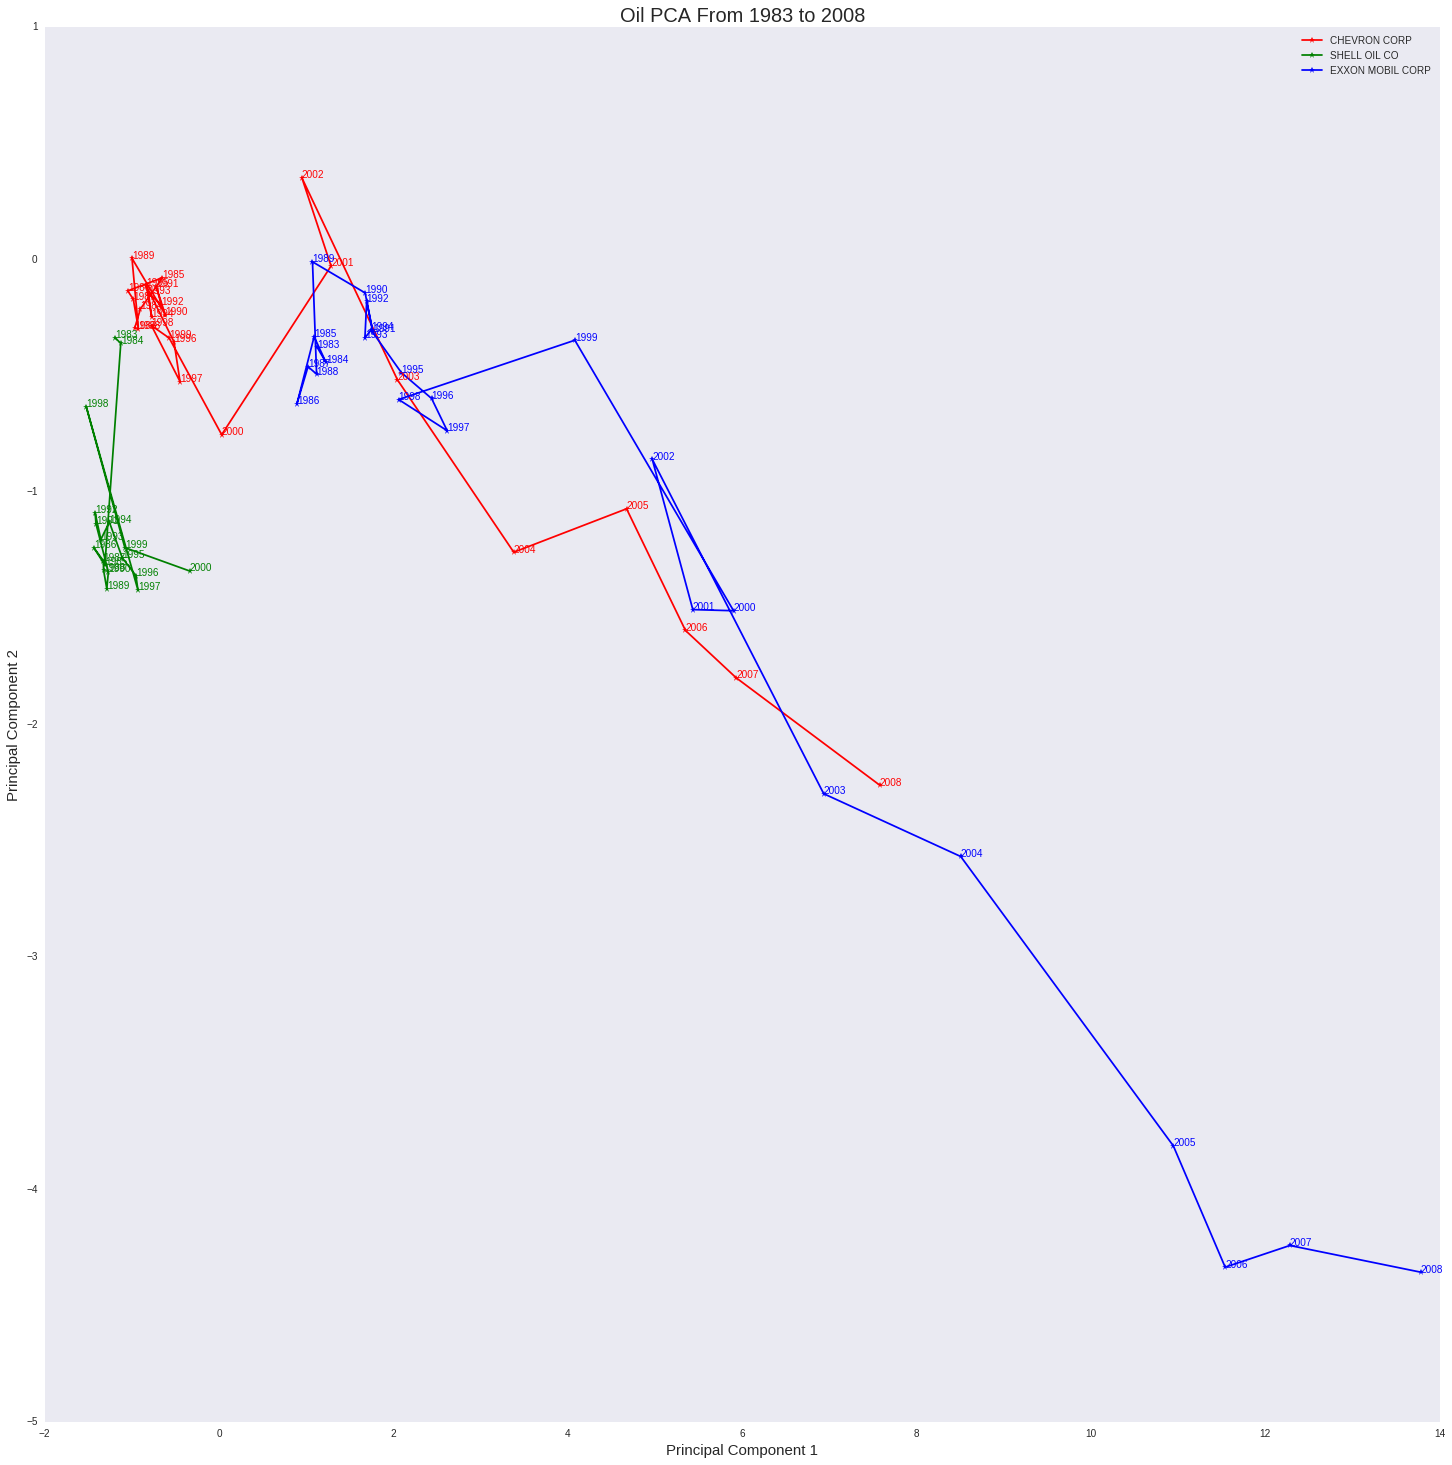

In [21]:
fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Oil PCA From 1983 to 2008', fontsize = 20)
companylist = Oil
colors = ['r','g','b']
for company, color in zip(companylist,colors):
    indicesToKeep = DBfrom1982to2002nonans['conm'] == company
    plt.plot(finalDf.loc[indicesToKeep, 'Principal Component 1']
               , finalDf.loc[indicesToKeep, 'Principal Component 2']
               , '-*'
               , c = color)
    for ttxt in zip(
            finalDf.loc[indicesToKeep, 'Principal Component 1'],
            finalDf.loc[indicesToKeep, 'Principal Component 2'],
            [ '%.0f'%y for y in finalDf.loc[indicesToKeep, 'fyear']]): 
        plt.text(ttxt[0], ttxt[1], ttxt[2], color = color)
ax.legend(companylist)
ax.grid()

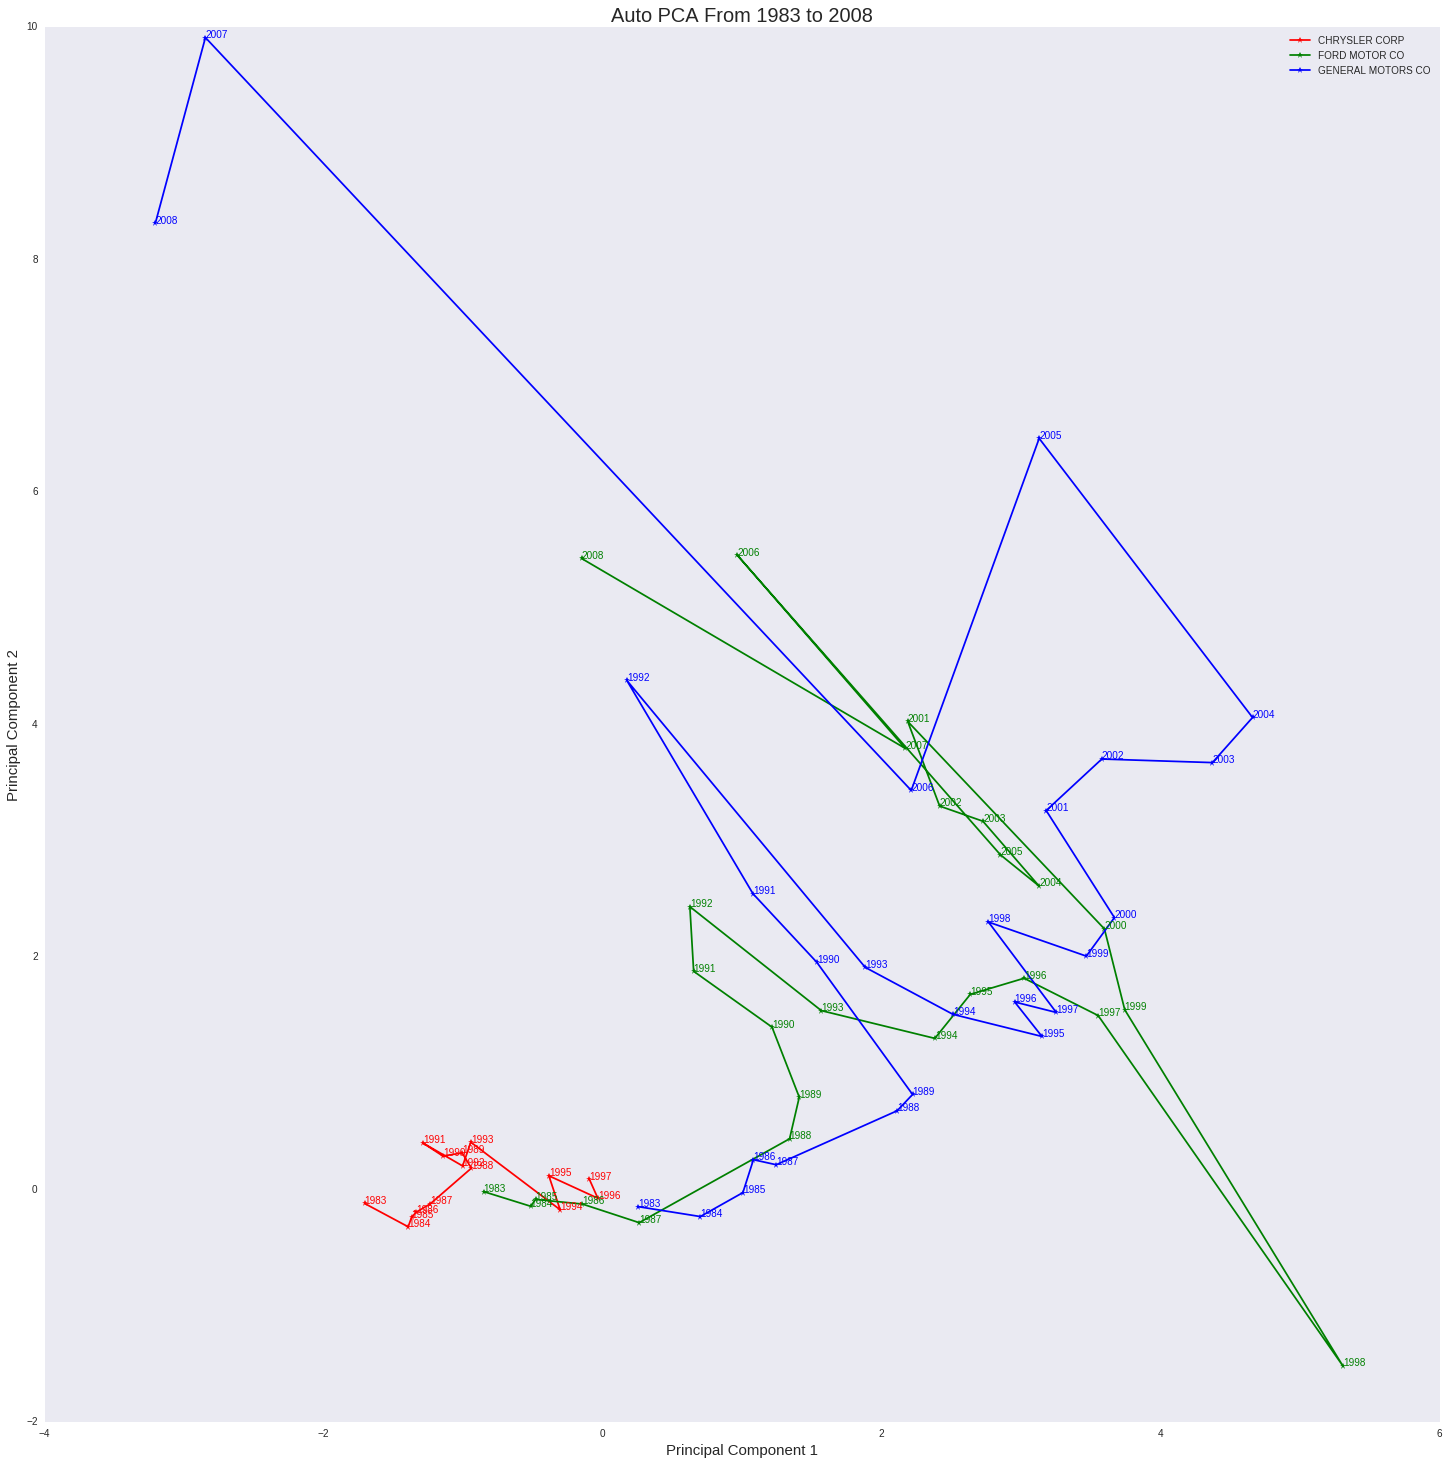

In [22]:
fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Auto PCA From 1983 to 2008', fontsize = 20)
companylist = Auto
colors = ['r','g','b']
for company, color in zip(companylist,colors):
    indicesToKeep = DBfrom1982to2002nonans['conm'] == company
    plt.plot(finalDf.loc[indicesToKeep, 'Principal Component 1']
               , finalDf.loc[indicesToKeep, 'Principal Component 2']
               , '-*'
               , c = color)
    for ttxt in zip(
            finalDf.loc[indicesToKeep, 'Principal Component 1'],
            finalDf.loc[indicesToKeep, 'Principal Component 2'],
            [ '%.0f'%y for y in finalDf.loc[indicesToKeep, 'fyear']]): 
        plt.text(ttxt[0], ttxt[1], ttxt[2], color = color)
ax.legend(companylist)
ax.grid()

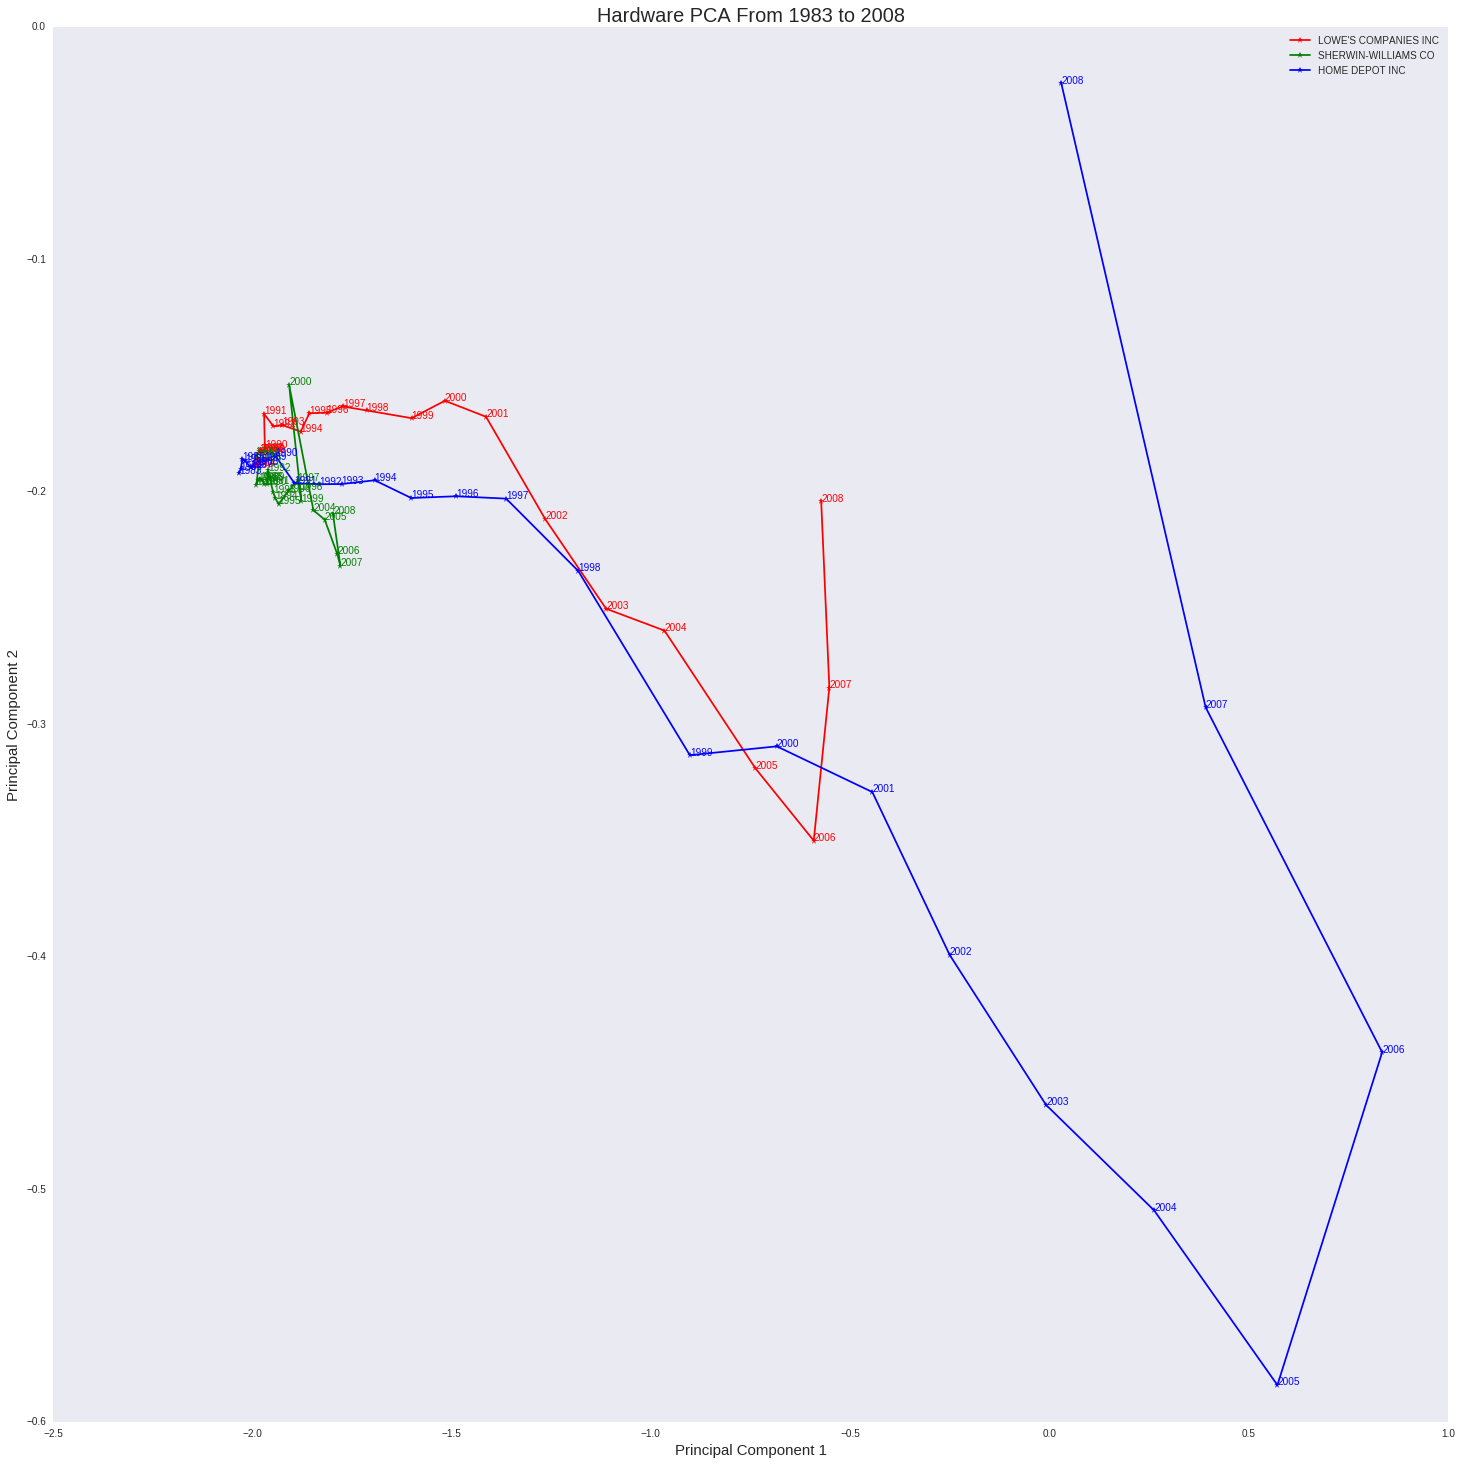

In [23]:
fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Hardware PCA From 1983 to 2008', fontsize = 20)
companylist = Hardware
colors = ['r','g','b']
for company, color in zip(companylist,colors):
    indicesToKeep = DBfrom1982to2002nonans['conm'] == company
    plt.plot(finalDf.loc[indicesToKeep, 'Principal Component 1']
               , finalDf.loc[indicesToKeep, 'Principal Component 2']
               , '-*'
               , c = color)
    for ttxt in zip(
            finalDf.loc[indicesToKeep, 'Principal Component 1'],
            finalDf.loc[indicesToKeep, 'Principal Component 2'],
            [ '%.0f'%y for y in finalDf.loc[indicesToKeep, 'fyear']]): 
        plt.text(ttxt[0], ttxt[1], ttxt[2], color = color)
ax.legend(companylist)
ax.grid()

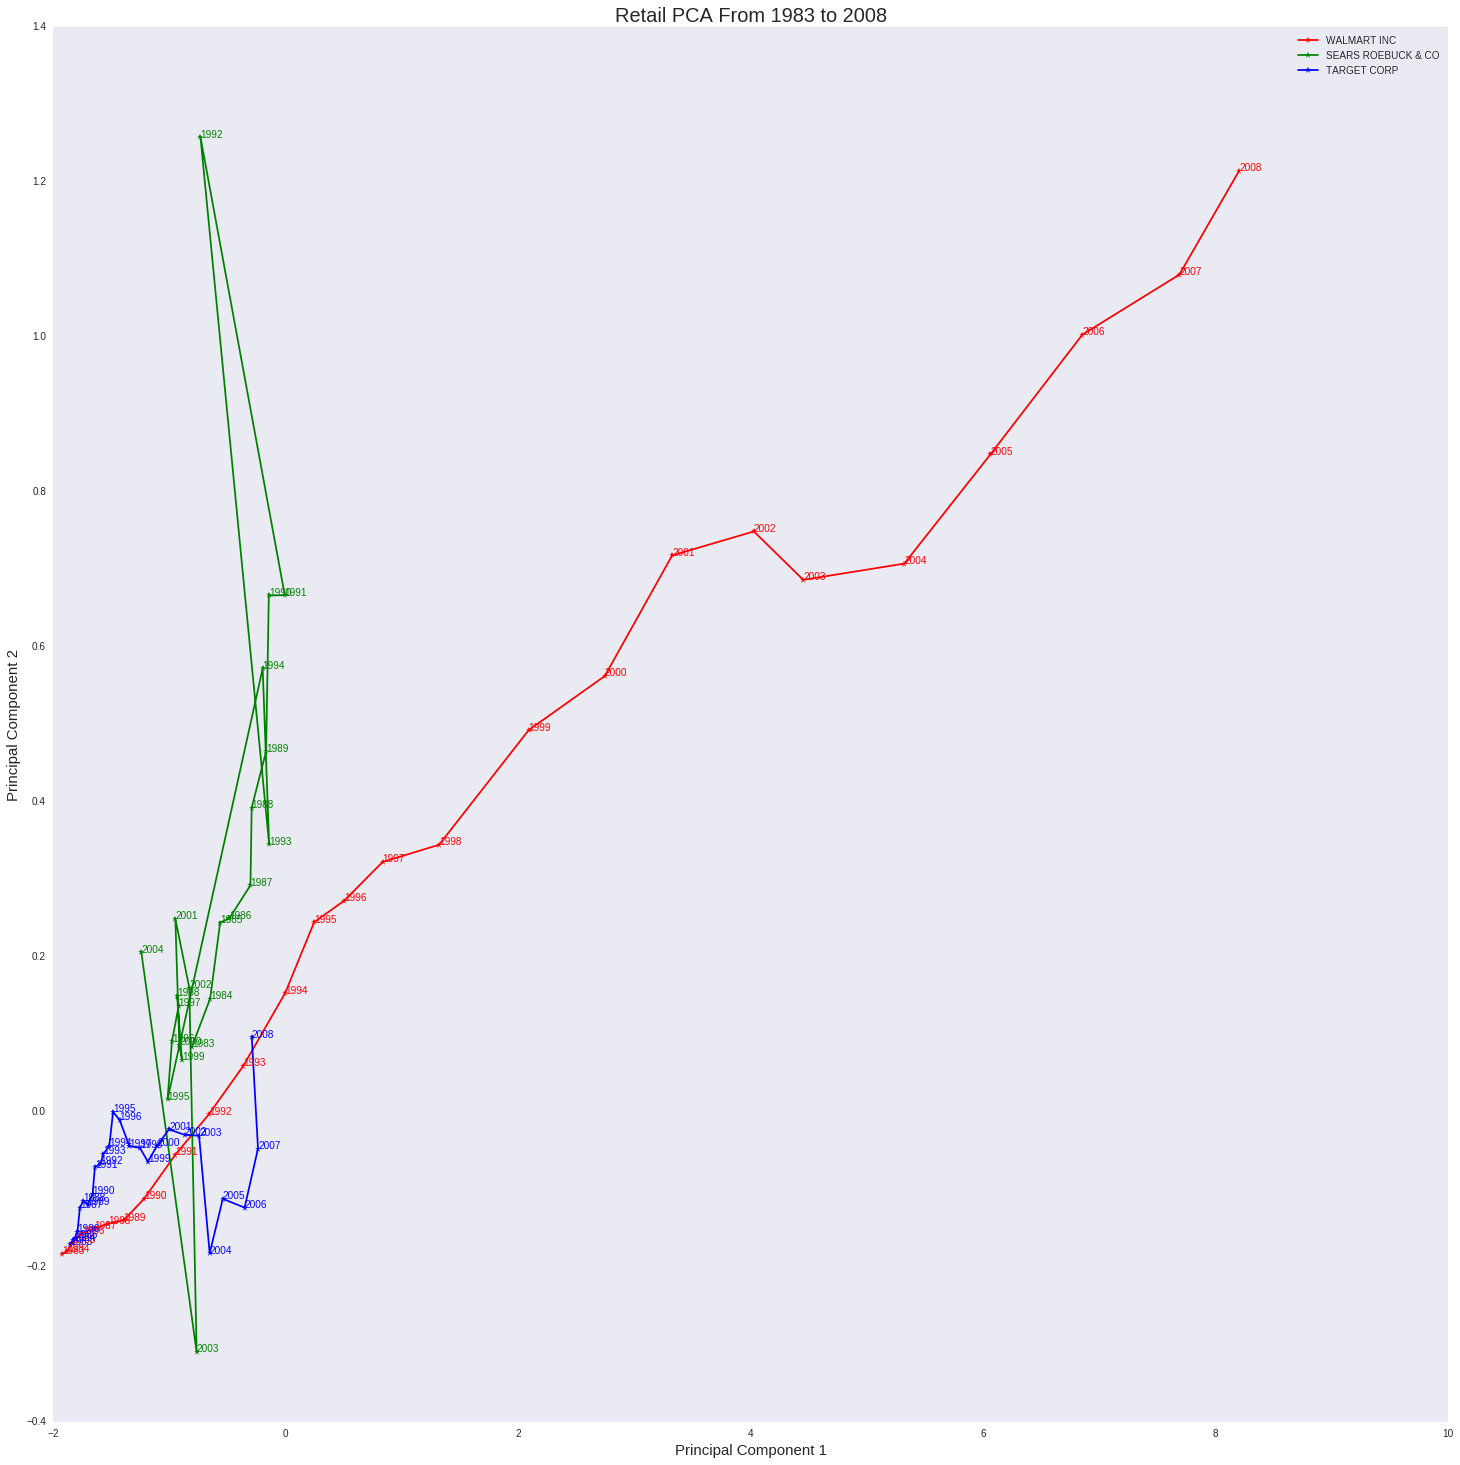

In [24]:
fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Retail PCA From 1983 to 2008', fontsize = 20)
companylist = Retail
colors = ['r','g','b']
for company, color in zip(companylist,colors):
    indicesToKeep = DBfrom1982to2002nonans['conm'] == company
    plt.plot(finalDf.loc[indicesToKeep, 'Principal Component 1']
               , finalDf.loc[indicesToKeep, 'Principal Component 2']
               , '-*'
               , c = color)
    for ttxt in zip(
            finalDf.loc[indicesToKeep, 'Principal Component 1'],
            finalDf.loc[indicesToKeep, 'Principal Component 2'],
            [ '%.0f'%y for y in finalDf.loc[indicesToKeep, 'fyear']]): 
        plt.text(ttxt[0], ttxt[1], ttxt[2], color = color)
ax.legend(companylist)
ax.grid()

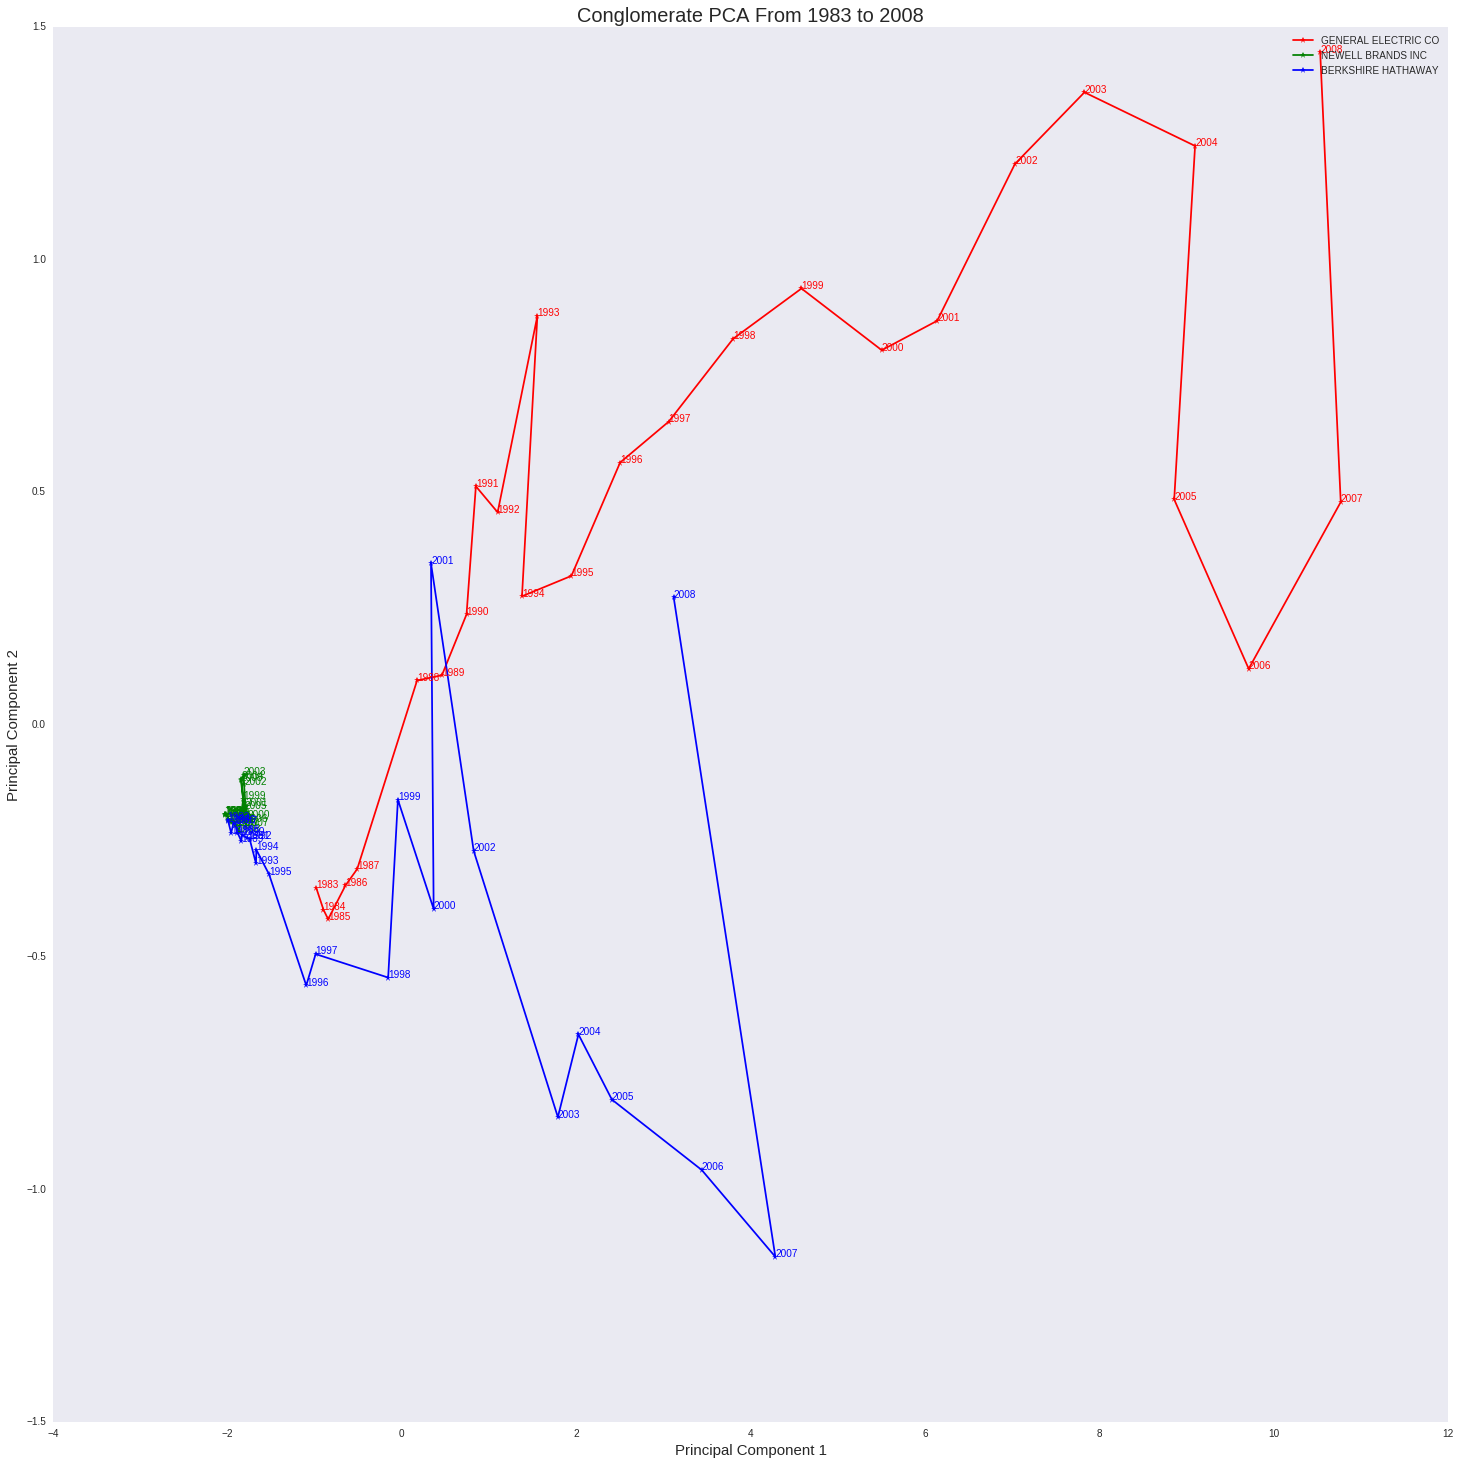

In [25]:
fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Conglomerate PCA From 1983 to 2008', fontsize = 20)
companylist = Conglomerate
colors = ['r','g','b']
for company, color in zip(companylist,colors):
    indicesToKeep = DBfrom1982to2002nonans['conm'] == company
    plt.plot(finalDf.loc[indicesToKeep, 'Principal Component 1']
               , finalDf.loc[indicesToKeep, 'Principal Component 2']
               , '-*'
               , c = color)
    for ttxt in zip(
            finalDf.loc[indicesToKeep, 'Principal Component 1'],
            finalDf.loc[indicesToKeep, 'Principal Component 2'],
            [ '%.0f'%y for y in finalDf.loc[indicesToKeep, 'fyear']]): 
        plt.text(ttxt[0], ttxt[1], ttxt[2], color = color)
ax.legend(companylist)
ax.grid()

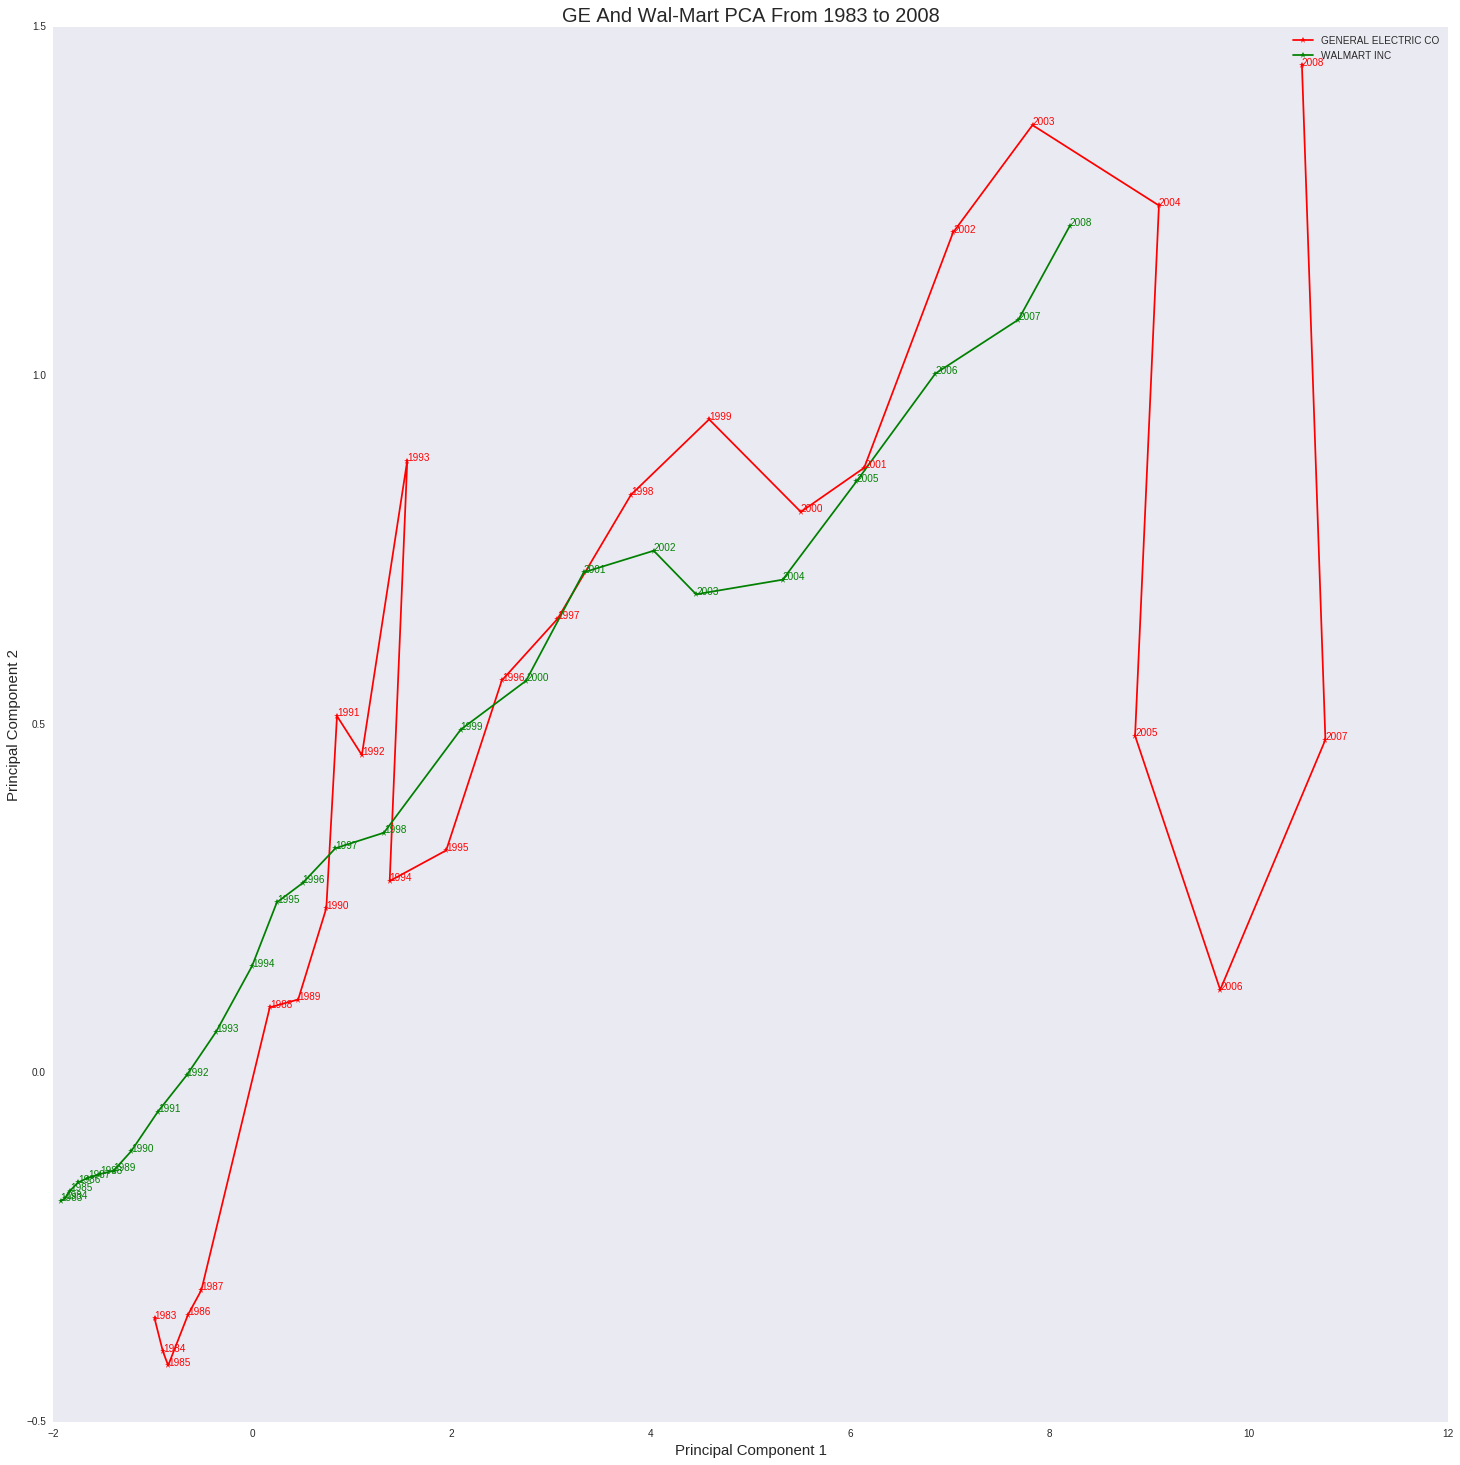

In [26]:
fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('GE And Wal-Mart PCA From 1983 to 2008', fontsize = 20)
companylist = ['GENERAL ELECTRIC CO','WALMART INC']
colors = ['r','g']
for company, color in zip(companylist,colors):
    indicesToKeep = DBfrom1982to2002nonans['conm'] == company
    plt.plot(finalDf.loc[indicesToKeep, 'Principal Component 1']
               , finalDf.loc[indicesToKeep, 'Principal Component 2']
               , '-*'
               , c = color)
    for ttxt in zip(
            finalDf.loc[indicesToKeep, 'Principal Component 1'],
            finalDf.loc[indicesToKeep, 'Principal Component 2'],
            [ '%.0f'%y for y in finalDf.loc[indicesToKeep, 'fyear']]): 
        plt.text(ttxt[0], ttxt[1], ttxt[2], color = color)
ax.legend(companylist)
ax.grid()

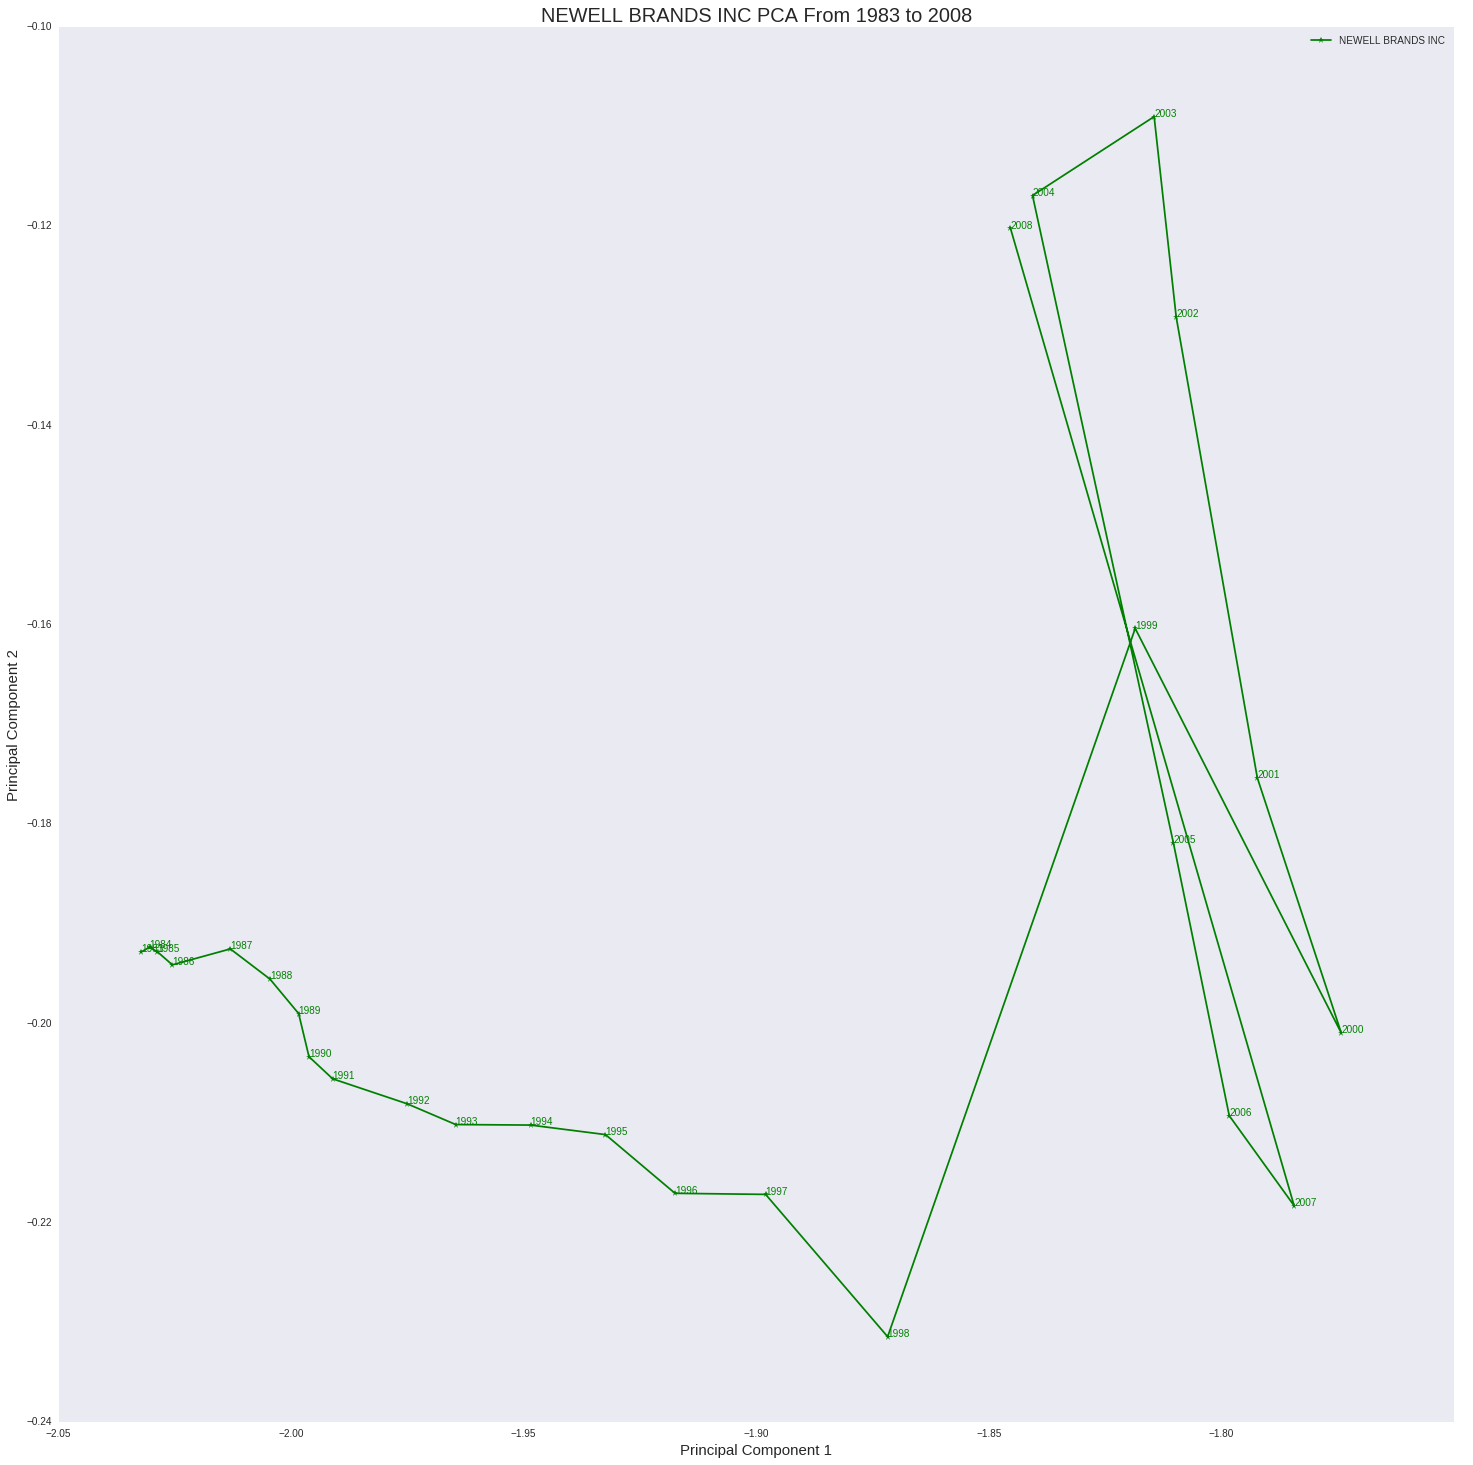

In [27]:
fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('NEWELL BRANDS INC PCA From 1983 to 2008', fontsize = 20)
companylist = ['NEWELL BRANDS INC']
colors = ['g']
for company, color in zip(companylist,colors):
    indicesToKeep = DBfrom1982to2002nonans['conm'] == company
    plt.plot(finalDf.loc[indicesToKeep, 'Principal Component 1']
               , finalDf.loc[indicesToKeep, 'Principal Component 2']
               , '-*'
               , c = color)
    for ttxt in zip(
            finalDf.loc[indicesToKeep, 'Principal Component 1'],
            finalDf.loc[indicesToKeep, 'Principal Component 2'],
            [ '%.0f'%y for y in finalDf.loc[indicesToKeep, 'fyear']]): 
        plt.text(ttxt[0], ttxt[1], ttxt[2], color = color)
ax.legend(companylist)
ax.grid()

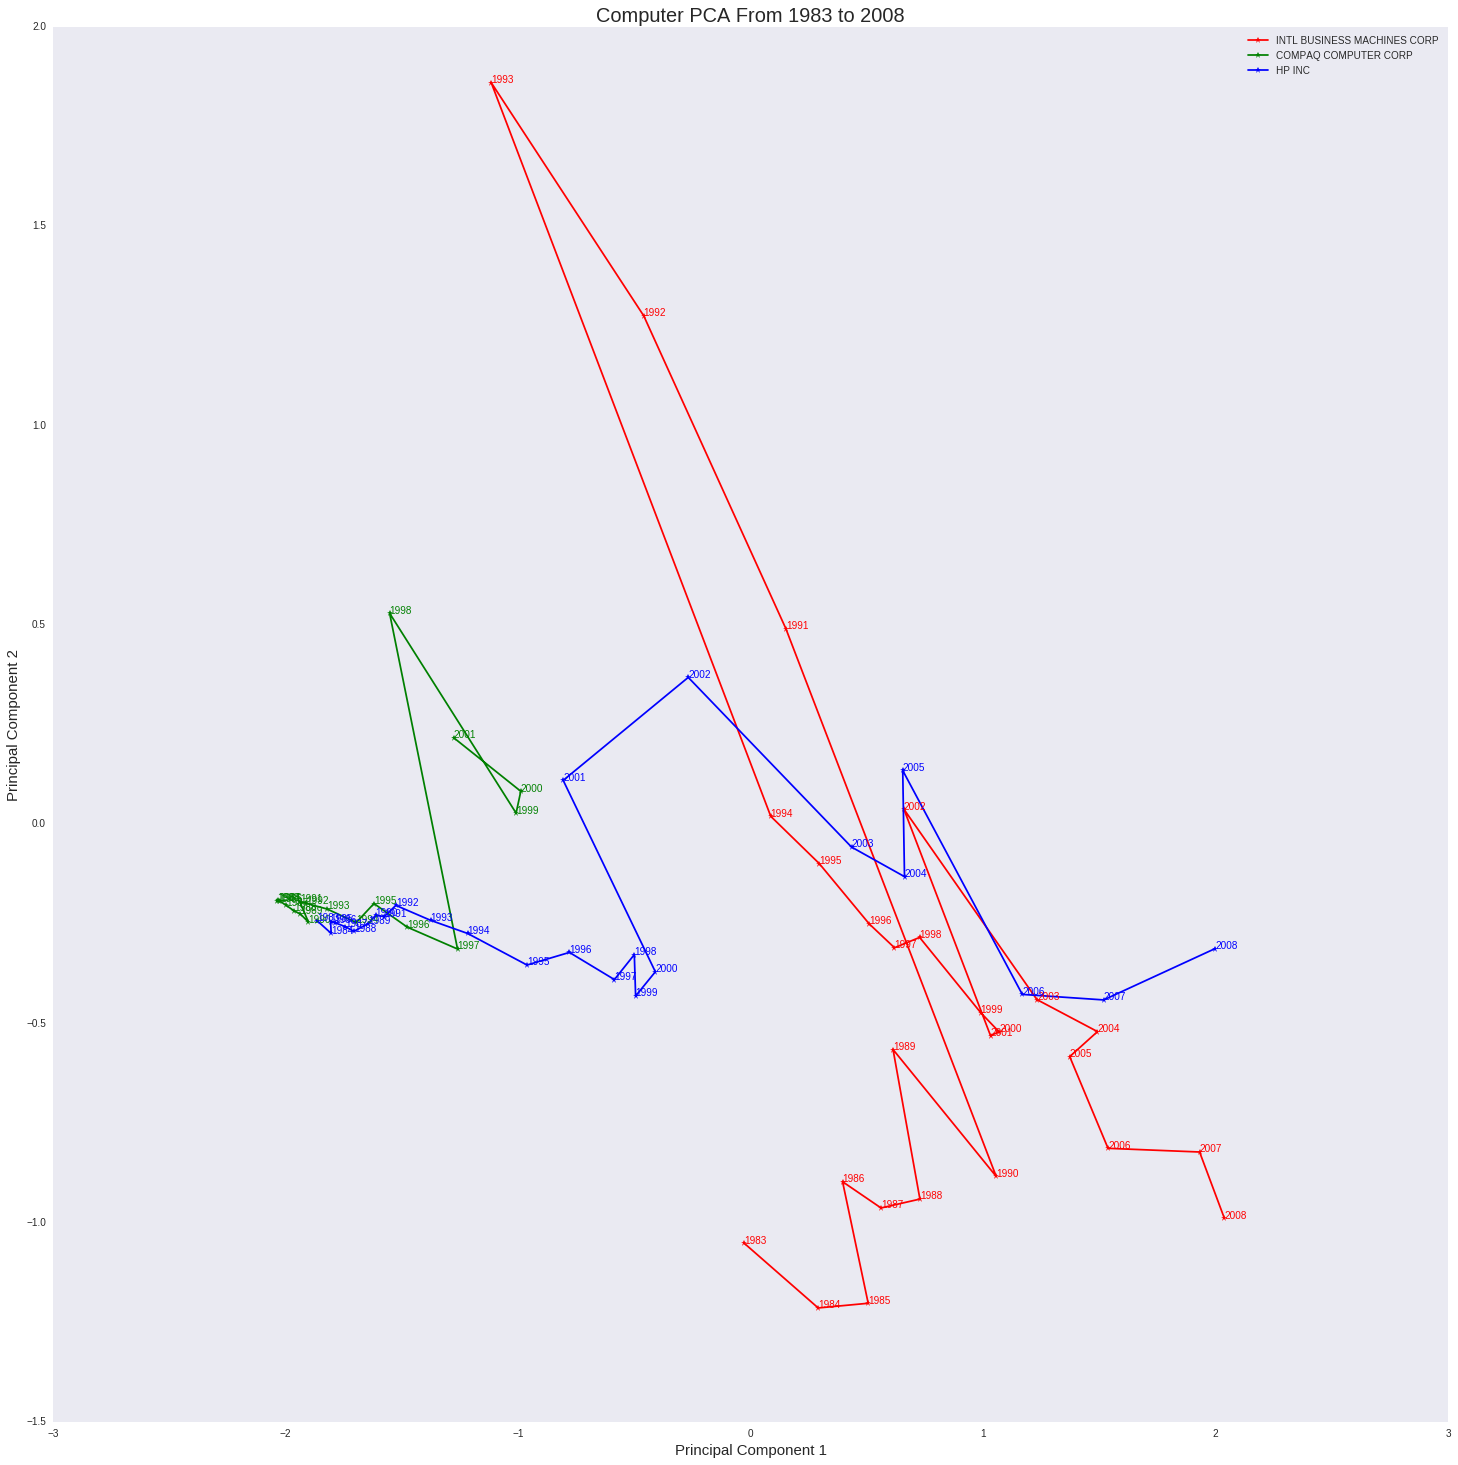

In [28]:
fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Computer PCA From 1983 to 2008', fontsize = 20)
companylist = Computer
colors = ['r','g','b']
for company, color in zip(companylist,colors):
    indicesToKeep = DBfrom1982to2002nonans['conm'] == company
    plt.plot(finalDf.loc[indicesToKeep, 'Principal Component 1']
               , finalDf.loc[indicesToKeep, 'Principal Component 2']
               , '-*'
               , c = color)
    for ttxt in zip(
            finalDf.loc[indicesToKeep, 'Principal Component 1'],
            finalDf.loc[indicesToKeep, 'Principal Component 2'],
            [ '%.0f'%y for y in finalDf.loc[indicesToKeep, 'fyear']]): 
        plt.text(ttxt[0], ttxt[1], ttxt[2], color = color)
ax.legend(companylist)
ax.grid()